In [1]:

import random
import numpy as np
import keras
import keras.layers
import keras.applications
import keras.backend
import keras.preprocessing.image
import keras.utils
import tensorflow as tf
from coord import CoordinateChannel2D
from keras.layers import Input,Conv2D
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [6]:
from keras.initializers import glorot_normal
from keras.optimizers import Adam

def outer_product(x):
    """
    calculate outer-products of 2 tensors

        args 
            x
                list of 2 tensors
                , assuming each of which has shape = (size_minibatch, total_pixels, size_filter)
    """
    return keras.backend.batch_dot(x[0], x[1], axes=[1,1]) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):
    """
    calculate element-wise signed square root

        args
            x
                a tensor
    """
    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):
    """
    calculate L2-norm

        args 
            x
                a tensor
    """
    return keras.backend.l2_normalize(x, axis=axis)


def build_model(
    size_heigth=128
    ,size_width=128
    ,no_class=5
    ,no_last_layer_backbone=17
    
    ,name_optimizer="Adam"
    ,rate_learning=1e-4
    ,rate_decay_learning=0.0
    ,rate_decay_weight=0.01
    
    ,name_initializer="glorot_normal"
    ,name_activation_logits="softmax"
    ,name_loss="categorical_crossentropy"

    ,flg_debug=False
    ,**kwargs
):
    
    keras.backend.clear_session()
    
    print("-------------------------------")
    print("parameters:")
    for key, val in locals().items():
        if not val == None and not key == "kwargs":
            print("\t", key, "=",  val)
    print("-------------------------------")
    
    ### 
    ### load pre-trained model
    ###
#     tensor_input = keras.layers.Input(shape=[size_heigth,size_width,3])
#     initial_model = VGG16(weights='imagenet', include_top=False)
    tensor_input = Input(shape=(128, 128, 1))
    out = CoordinateChannel2D()(tensor_input)
#     out = Conv2D(6,5,padding='valid',activation="relu")(out)
#     out = Conv2D(3,5,padding='valid',activation="relu")(out)
    model_detector = keras.applications.vgg19.VGG19(input_tensor = out ,include_top=False,weights="imagenet")
    

    ### 
    ### bi-linear pooling
    ###

    # extract features from detector
    x_detector = model_detector.layers[no_last_layer_backbone].output
    shape_detector = model_detector.layers[no_last_layer_backbone].output_shape
    if flg_debug:
        print("shape_detector : {}".format(shape_detector))

    # extract features from extractor , same with detector for symmetry DxD model
    shape_extractor = shape_detector
    x_extractor = x_detector
    if flg_debug:
        print("shape_extractor : {}".format(shape_extractor))
        
    
    # rehape to (minibatch_size, total_pixels, filter_size)
    x_detector = keras.layers.Reshape(
            [
                shape_detector[1] * shape_detector[2] , shape_detector[-1]
            ]
        )(x_detector)
    if flg_debug:
        print("x_detector shape after rehsape ops : {}".format(x_detector.shape))
        
    x_extractor = keras.layers.Reshape(
            [
                shape_extractor[1] * shape_extractor[2] , shape_extractor[-1]
            ]
        )(x_extractor)
    if flg_debug:
        print("x_extractor shape after rehsape ops : {}".format(x_extractor.shape))
        
        
    # outer products of features, output shape=(minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Lambda(outer_product)(
        [x_detector, x_extractor]
    )
    if flg_debug:
        print("x shape after outer products ops : {}".format(x.shape))
        
        
    # rehape to (minibatch_size, filter_size_detector*filter_size_extractor)
    x = keras.layers.Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
    if flg_debug:
        print("x shape after rehsape ops : {}".format(x.shape))
        
        
    # signed square-root 
    x = keras.layers.Lambda(signed_sqrt)(x)
    if flg_debug:
        print("x shape after signed-square-root ops : {}".format(x.shape))
        
    # L2 normalization
    x = keras.layers.Lambda(L2_norm)(x)
    if flg_debug:
        print("x shape after L2-Normalization ops : {}".format(x.shape))



    ### 
    ### attach FC-Layer
    ###

    if name_initializer != None:
            name_initializer = eval(name_initializer+"()")
    x = keras.layers.Dense(500)(x)
    x = keras.layers.Dropout(.2)(x)
    x = keras.layers.Dense(128)(x)
    x = keras.layers.Dropout(.2)(x)
    x = keras.layers.Dense(
            units=no_class
            ,kernel_regularizer=keras.regularizers.l2(rate_decay_weight)
            ,kernel_initializer=name_initializer
        )(x)
    if flg_debug:
        print("x shape after Dense ops : {}".format(x.shape))
    tensor_prediction = keras.layers.Activation(name_activation_logits)(x)
    if flg_debug:
        print("prediction shape : {}".format(tensor_prediction.shape))

        

    ### 
    ### compile model
    ###
    model_bilinear = keras.models.Model(
                        inputs=[tensor_input]
                        , outputs=[tensor_prediction]
                    )
    
    
    # fix pre-trained weights
    for layer in model_detector.layers:
        layer.trainable = False
        
        
    # define optimizers
    opt_adam = keras.optimizers.adam(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_rms = keras.optimizers.RMSprop(
                    lr=rate_learning
                    , decay=rate_decay_learning
                )
    opt_sgd = keras.optimizers.SGD(
                    lr=rate_learning
                    , decay=rate_decay_learning
                    , momentum=0.9
                    , nesterov=False
                )
    optimizers ={
        "adam":opt_adam
        ,"rmsprop":opt_rms
        ,"sgd":opt_sgd
    }
    
    model_bilinear.compile(
        loss=name_loss
        , optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        , metrics=['accuracy']
    )
    
    
    
    if flg_debug:
        model_bilinear.summary()
    
    return model_bilinear

In [7]:
Model=build_model()

-------------------------------
parameters:
	 size_heigth = 128
	 size_width = 128
	 no_class = 5
	 no_last_layer_backbone = 17
	 name_optimizer = Adam
	 rate_learning = 0.0001
	 rate_decay_learning = 0.0
	 rate_decay_weight = 0.01
	 name_initializer = glorot_normal
	 name_activation_logits = softmax
	 name_loss = categorical_crossentropy
	 flg_debug = False
-------------------------------


In [8]:
Model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
coordinate_channel2d_1 (Coordin (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        coordinate_channel2d_1[0][0]     
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_poo

In [10]:
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from dataLoader import data_loader

filepath = "weights_trans_data_extract_image-imp-{epoch:02d}-{val_acc:.2f}.hdf5"
# filepath="weights_BCNNVGG19_500_128-improvement-04-0.88.hdf5"
# Model.load_weights("weights_trans_Regu_image-imp-38-0.86.hdf5")

dataLoader = data_loader('data/train', 'data/val', 'data/test', data_size = 200)
train_generator, validation_generator, test_generator = dataLoader.load_images()
checkpoint_1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
checkpoint_2 =  TensorBoard(log_dir='logs/{}', histogram_freq=0, write_graph=True, write_images=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)
callbacks_list = [checkpoint_2,checkpoint_1,reduce_lr]

#X_train, Y_train, X_test, Y_test, val_data = dataLoader.load_images()
#print('Training data size', len(X_train))
#start = time.time()
train_steps = np.math.ceil(train_generator.samples / train_generator.batch_size)
val_steps = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
test_steps = np.math.ceil(test_generator.samples / test_generator.batch_size)

history = Model.fit_generator(train_generator, steps_per_epoch =train_steps, epochs = 50,callbacks=callbacks_list,validation_data=validation_generator,validation_steps = val_steps)
# print('--------Test data--------')

x = Model.evaluate_generator(test_generator, steps =test_steps, verbose = 1)
print(x)


Found 8750 images belonging to 5 classes.
Found 3739 images belonging to 5 classes.
Found 1240 images belonging to 5 classes.
Epoch 1/50
69/69 [==============================] - 15s 211ms/step - loss: 0.2332 - acc: 0.8857 - val_loss: 0.2580 - val_acc: 0.8550

Epoch 00001: val_acc improved from -inf to 0.85504, saving model to weights_trans_data_extract_image-imp-01-0.86.hdf5
Epoch 2/50
69/69 [==============================] - 14s 210ms/step - loss: 0.2321 - acc: 0.8870 - val_loss: 0.2577 - val_acc: 0.8556

Epoch 00002: val_acc improved from 0.85504 to 0.85558, saving model to weights_trans_data_extract_image-imp-02-0.86.hdf5
Epoch 3/50
69/69 [==============================] - 14s 210ms/step - loss: 0.2324 - acc: 0.8901 - val_loss: 0.2579 - val_acc: 0.8556

Epoch 00003: val_acc improved from 0.85558 to 0.85558, saving model to weights_trans_data_extract_image-imp-03-0.86.hdf5
Epoch 4/50
69/69 [==============================] - 15s 210ms/step - loss: 0.2311 - acc: 0.8903 - val_loss: 0.25

69/69 [==============================] - 14s 210ms/step - loss: 0.2310 - acc: 0.8915 - val_loss: 0.2576 - val_acc: 0.8564

Epoch 00043: val_acc did not improve from 0.85852
Epoch 44/50
69/69 [==============================] - 14s 209ms/step - loss: 0.2315 - acc: 0.8905 - val_loss: 0.2576 - val_acc: 0.8564

Epoch 00044: val_acc did not improve from 0.85852
Epoch 45/50
69/69 [==============================] - 14s 210ms/step - loss: 0.2287 - acc: 0.8917 - val_loss: 0.2576 - val_acc: 0.8564

Epoch 00045: val_acc did not improve from 0.85852
Epoch 46/50
69/69 [==============================] - 14s 210ms/step - loss: 0.2307 - acc: 0.8890 - val_loss: 0.2576 - val_acc: 0.8564

Epoch 00046: val_acc did not improve from 0.85852
Epoch 47/50
69/69 [==============================] - 14s 209ms/step - loss: 0.2313 - acc: 0.8889 - val_loss: 0.2576 - val_acc: 0.8564

Epoch 00047: val_acc did not improve from 0.85852
Epoch 48/50
69/69 [==============================] - 14s 209ms/step - loss: 0.2311 - ac

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


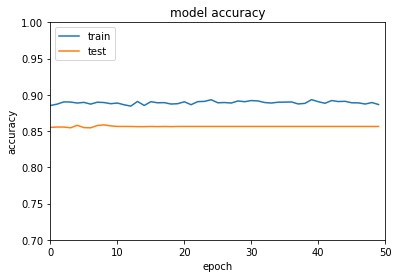

In [11]:
import matplotlib.pyplot as plt

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
axes = plt.gca()
axes.set_xlim([0,50])
axes.set_ylim([0.7,1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("accuray.eps",format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


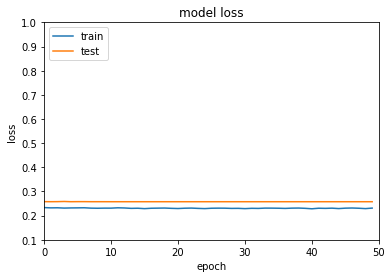

In [12]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
axes = plt.gca()
axes.set_xlim([0,50])
axes.set_ylim([0.1,1])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("model_loss.eps",format='eps')
plt.savefig("model_loss.png",format='png')
plt.show()

In [26]:
# Model.load_weights("weights_trans_Regu_image-imp-38-0.86.hdf5")
class_labels = ['centred', 'hexagonal', 'noise', 'oblique','rectangular']

In [27]:
from sklearn.metrics import confusion_matrix


In [28]:
def plot_confusion_matrix(cm ,classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.savefig("confusion_matrix.eps")
    return ax

In [29]:
predict = []
label =[]
i=0
for inputs , labels in test_generator:
    predict.append(np.array((np.argmax((Model.predict(inputs)),axis=-1))))
    label.append(np.array((np.argmax(labels,axis=-1))))
#     print(predict)
    i+=1
    if i >test_steps:
        break
#     print(predict)

In [30]:
import itertools
label = list(itertools.chain.from_iterable(label))
predict = list(itertools.chain.from_iterable(predict))

In [31]:
cm = confusion_matrix(label, predict)

Normalized confusion matrix


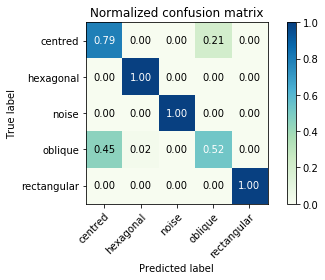

In [40]:
plot_confusion_matrix(cm,classes=class_labels,cmap="GnBu")